In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

from joblib import dump

In [2]:
path = './'

In [3]:
stop_words = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer()

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: (stemmer.stem(w) for w in analyzer(doc))

In [13]:
# import data
data = pd.read_csv(path + 'data.csv')

In [14]:
data = data.set_index('id')

In [15]:
data.head()

,title,overview,genre
id,,,
862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",Animation
8844,Jumanji,When siblings Judy and Peter discover an encha...,Adventure
15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,Romance
31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",Comedy
11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy


In [ ]:
# define input text as concatenation of title and overview
data['text'] = data.apply(lambda x: x['title'] + ' ' + x['overview'], axis=1)

In [16]:
data.head()

,title,overview,genre,text
id,,,,
862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",Animation,"Toy Story Led by Woody, Andy's toys live happi..."
8844,Jumanji,When siblings Judy and Peter discover an encha...,Adventure,Jumanji When siblings Judy and Peter discover ...
15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,Romance,Grumpier Old Men A family wedding reignites th...
31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",Comedy,"Waiting to Exhale Cheated on, mistreated and s..."
11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy,Father of the Bride Part II Just when George B...


In [17]:
train, test = train_test_split(data, test_size=0.1, random_state=17)

In [18]:
train.shape, test.shape

((38088, 4), (4233, 4))

In [20]:
tfidf = StemmedTfidfVectorizer(stop_words=stop_words)

In [21]:
train_tfidf = tfidf.fit_transform(train['text'])

In [22]:
train_tfidf.shape

(38088, 55162)

### Features Reduction

In [23]:
n = 2000
svd = TruncatedSVD(n_components=n, random_state=11)
svd.fit_transform(train_tfidf)
var = np.cumsum(svd.explained_variance_ratio_*100)

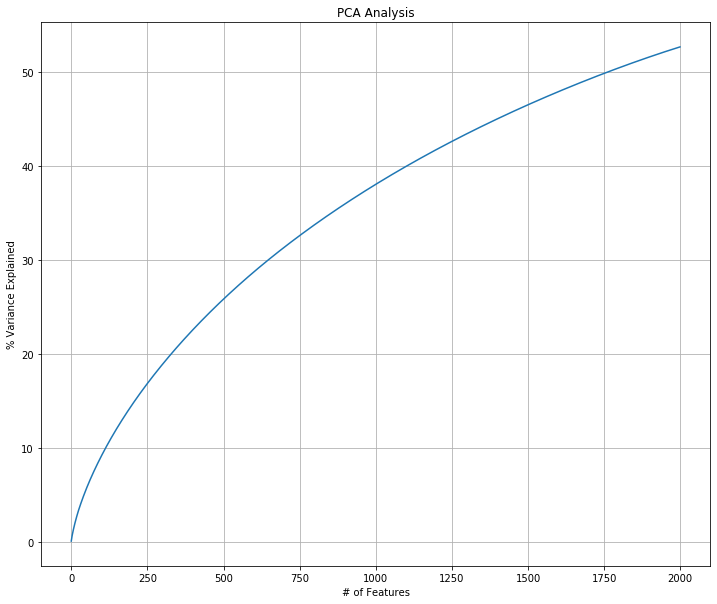

In [24]:
plt.figure(figsize=(12,10))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')

plt.plot(var)
plt.grid()

In [25]:
svd = TruncatedSVD(n_components=600, random_state=11)
X_train = svd.fit_transform(train_tfidf)
print(sum(svd.explained_variance_ratio_))

0.28382533808004784


In [26]:
y_train = train['genre'].values

In [27]:
y_train.shape, X_train.shape

((38088,), (38088, 600))

In [28]:
train['genre'].value_counts()

Drama              10606
Comedy              7638
Action              4049
Documentary         3049
Horror              2348
Crime               1481
Thriller            1456
Adventure           1354
Romance             1067
Animation           1006
Fantasy              623
Science Fiction      575
Mystery              498
Family               459
Music                434
Western              412
TV Movie             348
War                  336
History              246
Foreign              103
Name: genre, dtype: int64

### Model Selection

In [29]:
# model selection
parameters = {'n_estimators': [50, 100],
              'class_weight': ['balanced', None],
              'max_depth': [20, 35, 50]
             }
gridsearch = GridSearchCV(RandomForestClassifier(), parameters, cv=4, n_jobs=-1, verbose=10)
gridsearch.fit(X_train, y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed: 10.9min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed: 11.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 12.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 12.8min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [30]:
gridsearch.best_params_, gridsearch.best_score_

({'class_weight': None, 'max_depth': 20, 'n_estimators': 100},
 0.3621613106490233)

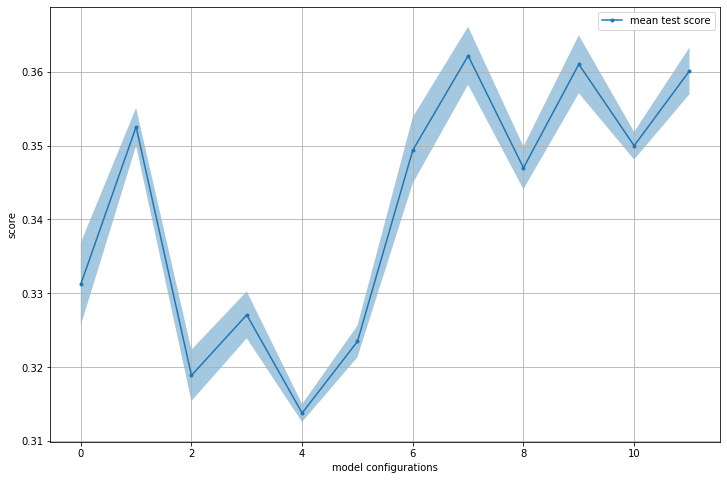

In [43]:
mean_score = gridsearch.cv_results_['mean_test_score']
std_score = gridsearch.cv_results_['std_test_score']

plt.figure(figsize=(12, 8))
plt.plot(mean_score, marker='.', label='mean test score')
plt.fill_between(range(len(mean_score)), 
                 mean_score - std_score,
                 mean_score + std_score,
                 alpha=0.4)
plt.xlabel('model configurations')
plt.ylabel('score')
plt.legend()
plt.grid()

In [32]:
best_hyp_param = gridsearch.best_params_

### Model train and test

In [33]:
movieclf = RandomForestClassifier(**best_hyp_param, random_state=15)

In [34]:
movieclf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=15, verbose=0,
                       warm_start=False)

In [35]:
# transform test data using tfidf and svd objects fitted with train data
test_tfidf = tfidf.transform(test['text'])
X_test = svd.transform(test_tfidf)

In [36]:
y_test = test['genre'].values

In [37]:
X_test.shape, y_test.shape

((4233, 600), (4233,))

In [38]:
movieclf.score(X_test, y_test)

0.3586109142452162

In [39]:
# use confusion matrix to get an overall idea of performance
pd.DataFrame(confusion_matrix(y_test, movieclf.predict(X_test)), 
             columns=movieclf.classes_, 
             index=movieclf.classes_
            )

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
Action,97,0,0,49,0,5,260,0,0,0,0,4,0,0,0,0,0,0,0,0
Adventure,17,2,0,22,0,2,104,0,0,0,0,1,0,0,0,0,0,0,0,0
Animation,7,0,0,28,0,2,70,0,0,0,0,0,0,0,0,0,0,0,0,0
Comedy,24,0,0,256,0,11,584,0,0,0,0,3,0,0,0,1,0,0,0,0
Crime,20,0,0,27,0,1,132,0,0,0,0,2,0,0,0,0,0,0,0,0
Documentary,5,0,0,32,0,125,165,0,0,0,0,0,0,0,0,0,0,0,0,0
Drama,29,0,1,147,0,9,1011,0,0,0,0,0,0,0,0,1,0,0,0,0
Family,0,0,0,15,0,0,33,0,0,0,0,1,0,0,0,0,0,0,0,0
Fantasy,4,0,0,16,0,1,49,0,0,0,0,3,0,0,0,0,0,0,0,0
Foreign,1,0,0,0,0,2,10,0,0,0,0,0,0,0,0,0,0,0,0,0


### Save classifier, tfidf and svd objects

In [40]:
mpath = 'models/'
dump(movieclf, mpath + 'movieclassifier.joblib')
dump(tfidf, mpath + 'tfidf.joblib')
dump(svd, mpath + 'svd.joblib');